# Spotify Analysis: Predicting Song Popularity

## 1 Introduction

Streaming services like Spotify provide consumers with easy access to the latest music. In this project, we used a database collected using the Spotify API, which contains information on the mode, genres, acousticness, danceability, duration, energy, instrumentalness, liveness, speechiness, tempo, valance, and key of over 600,000 tracks. Attached to each genre is their popularity score based on total plays and recency. Our goal is to investigate ways to predict a song's popularity using the song’s attributes. We will be investigating the following research questions: 

<div align="center"><strong>Can we predict if a particular song is likely to be popular?<strong></div>

<div align="center"><strong>If so, which features can best determine a song's popularity?<strong></div>

## 2 Preliminary Exploratory Data Analysis
### 2.1 Running Necessary Packages

In [2]:
library(tidyverse) #basic data wrangling
library(tidymodels) #knn regression and linear regression
library(GGally) #ggpairs multivariate analysis
library(cowplot)
install.packages("ggthemes") # Install 
library(ggthemes) # Load

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



### 2.2 Reading and Tidying Data

Wrangling and tidying will be a necessary first step to all data analysis procedures. From the raw dataset imported, we manually sort through them to find 3 categorical and 11 quantitative variables. Because the raw data already followed the general guidelines of tidy data, the only step left in tidying is to `mutate` the categorical variables into factor type. This communicates to R that the variables mode, key and genres should be treated as discrete values -- streamlining and improving the quality of plots for the rest of the analysis. 

Although k-nearest neighbors classification and regression only predicts quantitative inputs, we believe it is still worthwhile to explore the categorical variables within the preliminary analysis to discover potential trends relevant to the final discussion.

Finally, a `which` and `na.omit` function are executed to check for any missing value observations as they could result in NA values in downstream calculations of the regression models decreasing the effectiveness of the model. Fortunately no NA values were found.

In [3]:
options(scipen = 999) #Non-scientific notation

genre_data = read_csv("https://raw.githubusercontent.com/paulh777/dsci100prj/main/proposal/data_by_genres.csv")

#Mutating the categorical variables as factors
popularity_data = genre_data %>%
    mutate(mode = as_factor(mode))%>%
    mutate(key = as_factor(key))%>%
    mutate(genres = as_factor(genres))

#Table Preview
popularity_data %>% head(10) 

#Check for NA values
which(is.na(popularity_data))
na.omit(popularity_data)
#No NA rows found

Parsed with column specification:
cols(
  mode = col_double(),
  genres = col_character(),
  acousticness = col_double(),
  danceability = col_double(),
  duration_ms = col_double(),
  energy = col_double(),
  instrumentalness = col_double(),
  liveness = col_double(),
  loudness = col_double(),
  speechiness = col_double(),
  tempo = col_double(),
  valence = col_double(),
  popularity = col_double(),
  key = col_double()
)



mode genres                 acousticness danceability duration_ms energy    
1  1    21st century classical 0.9793333    0.1628833     160297.7   0.07131667
2  1    432hz                  0.4947800    0.2993333    1048887.3   0.45067833
3  1    8-bit                  0.7620000    0.7120000     115177.0   0.81800000
4  1    []                     0.6514170    0.5290926     232880.9   0.41914607
5  1    a cappella             0.6765573    0.5389612     190628.5   0.31643357
6  1    abstract               0.4592100    0.5161667     343196.5   0.44241667
7  1    abstract beats         0.3421467    0.6230000     229936.2   0.52780000
8  1    abstract hip hop       0.2438541    0.6945709     231849.2   0.64623464
9  0    accordeon              0.3230000    0.5880000     164000.0   0.39200000
10 1    accordion              0.4461250    0.6248125     167061.6   0.37343750
   instrumentalness liveness   loudness   speechiness tempo    valence  
1  0.606833670      0.36160000 -31.514333 0.04056667   75.3365 0.1037833
2  0.477761667      0.13100000 -16.854000 0.07681667  120.2857 0.2217500
3  0.876000000      0.12600000  -9.180000 0.04700000  133.4440 0.9750000
4  0.205309190      0.21869585 -12.288965 0.10787156  112.8574 0.5136043
5  0.003003441      0.17225414 -12.479387 0.08285144  112.1104 0.4482487
6  0.849666667      0.11806667 -15.472083 0.04651667  127.8858 0.3073250
7  0.333602612      0.09965333  -7.918000 0.11637333  112.4138 0.4935067
8  0.024231263      0.16854292  -7.349328 0.21425770  108.2450 0.5713909
9  0.441000000      0.07940000 -14.899000 0.07270000  109.1310 0.7090000
10 0.193738394      0.16030000 -14.487063 0.07853750  112.8724 0.6586875
   popularity key
1  27.83333   6  
2  52.50000   5  
3  48.00000   7  
4  20.85988   7  
5  45.82007   7  
6  43.50000   1  
7  58.93333   10 
8  39.79070   2  
9  39.00000   2  
10 21.93750   2

integer(0)

### 2.3 Initial Split

When we split our data into its training and testing sets, we chose a 50/50 split (50% of the data in each subsets) because the dataset has 2,973 observations. The number of observations was deemed by our group to be reasonably large enough to allow for sufficient observations to be dedicated to the testing set without compromising the accuracy from the training side.

In [4]:
#Initial Split
popularity_num = popularity_data%>%
    select(-key,-genres,-mode) #Removing categorical variables

popularity_split = initial_split(popularity_num, prop = 0.5, strata = popularity)
popularity_training = training(popularity_split)
popularity_testing = testing(popularity_split)

### 2.4 Exploratory Tables
#### 2.4.1 Summary Table of Quantitative Variables

To get a brief summary of the variable characteristics, we decide to calculate the `max`, `min`, `median`, and the `sd` (standard deviation) of each variable  within our training dataset.

To calculate the `max`, `min`, `median`, and the `sd` of each variable, we make 5 separate tables for each summary statistic respectively using the `map_df` function to apply each summary statistic calculation to each variable. We then combined all 5 tables using the `bind_cols` function to form one, comprehensive summary table.

In [114]:
#Summary Table of Quantitative Variables

#Converted the `duration` variable from  milliseconds to minutes just for this table for better interpretation and readability.
popularity_num2 = popularity_training%>%
    mutate(duration_min=duration_ms/60000)%>%
    select(-duration_ms)

popularity_max = popularity_num2 %>%
    map_df(max, na.rm=TRUE)

popularity_min = popularity_num2 %>%
    map_df(min, na.rm=TRUE)

popularity_mean = popularity_num2 %>%
    map_df(mean, na.rm=TRUE)

popularity_median = popularity_num2 %>%
    map_df(median, na.rm=TRUE)

popularity_sd = popularity_num2 %>%
    map_df(sd, na.rm=TRUE)

#Before we can combine the 5 summary statistic tables, we wrangle the data so it is in tidy format using `pivot_longer`
popularity_max = popularity_max %>%
    pivot_longer(
        cols = acousticness:duration_min,
        names_to = "variable",
        values_to = "max"
    )

popularity_min = popularity_min %>%
    pivot_longer(
        cols = acousticness:duration_min,
        names_to = "remove1",
        values_to = "min"
    )

popularity_mean = popularity_mean %>%
    pivot_longer(
        cols = acousticness:duration_min,
        names_to = "remove2",
        values_to = "mean"
    )

popularity_median = popularity_median %>%
    pivot_longer(
        cols = acousticness:duration_min,
        names_to = "remove3",
        values_to = "median"
    )

popularity_sd = popularity_sd %>%
    pivot_longer(
        cols = acousticness:duration_min,
        names_to = "remove4",
        values_to = "standard_deviation"
    )

#Combining the separate tables into one one comprehensive table
popularity_table = popularity_max %>%
    bind_cols(popularity_min)%>%
    bind_cols(popularity_mean)%>%
    bind_cols(popularity_median)%>%
    bind_cols(popularity_sd)%>%
    select(variable,max,min,mean,median,standard_deviation)

popularity_table

variable         max         min          mean         median      
1  acousticness       0.9950000   0.00000271   0.39668456   0.31160497
2  danceability       0.9030000   0.05690000   0.53721015   0.54699323
3  energy             0.9870000   0.00395000   0.56187394   0.60476333
4  instrumentalness   0.9910000   0.00000000   0.20813480   0.07850201
5  liveness           0.7998333   0.02220000   0.19032992   0.17478316
6  loudness          -0.9100000 -37.61950000 -10.51373569  -9.19525000
7  speechiness        0.9462187   0.02380000   0.08416484   0.05944017
8  tempo            200.3410000  56.43600000 118.88103718 118.77015349
9  valence            0.9754000   0.01335400   0.49684954   0.50140442
10 popularity        78.5000000   0.00000000  40.08635142  43.05936546
11 duration_min      27.0333333   0.71355000   4.18800231   3.94665460
   standard_deviation
1   0.31824614       
2   0.15066212       
3   0.23420211       
4   0.26474839       
5   0.09113386       
6   5.31909086       
7   0.08293113       
8  17.51354238       
9   0.20202071       
10 16.37759909       
11  1.52008938

#### 2.4.2 Spread Visualization: Histogram of Popularity

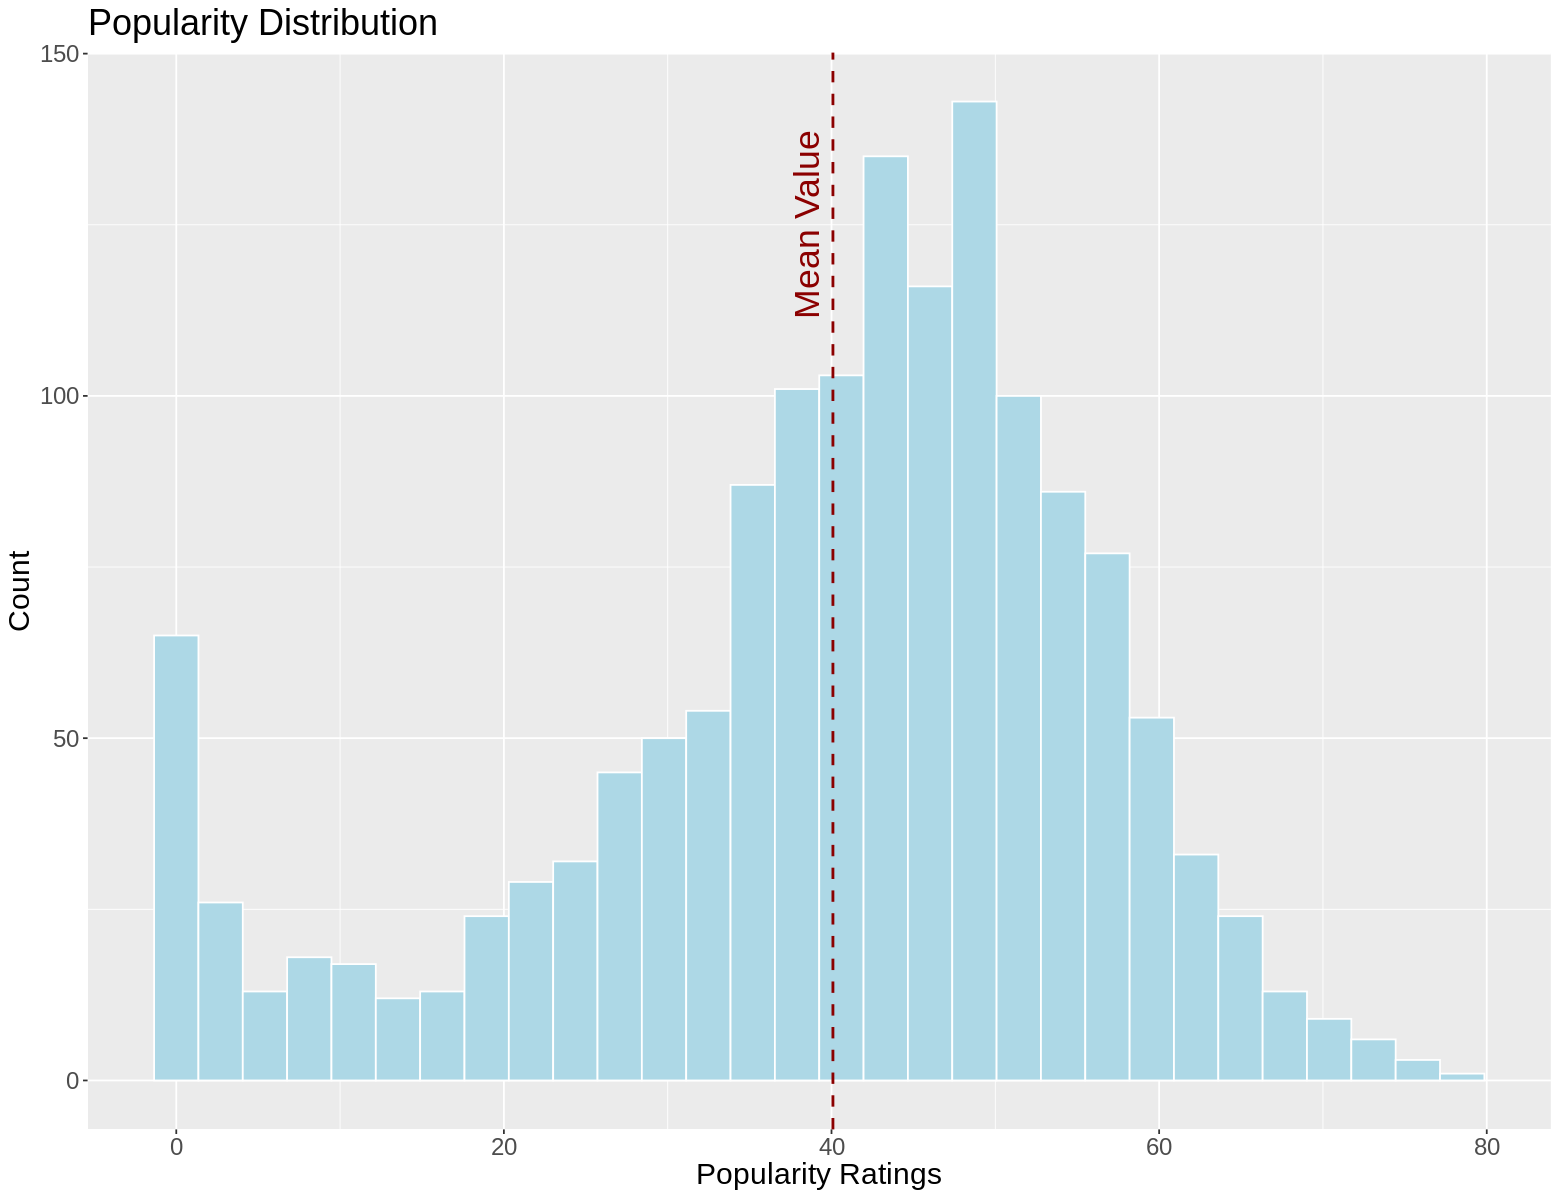

In [154]:
options(repr.plot.width = 13, repr.plot.height = 10)

pop_hist = popularity_training %>%
    ggplot(aes(x=popularity)) +
    geom_histogram(bins=30, colour="white", fill="lightblue") +
    labs(x="Popularity Ratings", y= "Count", title="Popularity Distribution")+
    theme(text = element_text(size = 18)) +
    geom_vline(xintercept = 40.086, linetype = "dashed", size = 0.8, colour= "darkred") +
    annotate("text", x=38.5, y=125, label = "Mean Value", size=7.5, angle=90, colour="darkred")

pop_hist

If we analyze the summary statistics table alongside the popularity histogram, an interesting insight can be made: although the mean popularity is around the 40's, most songs actually fall close to the 50's bin. This is because the histogram is **bimodal:** many songs (surprisingly) have a popularity score of 0, which results in the mean popularity value being pulled away from the middle peak of the histogram towards a lower value. This will be important in the future for whneinterpreting how popular a song is. For example, if we find a song with a popularity rating of 45, we may initially think it is "popular" because it is higher than the mean and median; however, since the histogram is bimodal, those values may actually not be representative of the actual meaning of "popular", since the histogram is centered around the 50's.

### 2.5 Exploratory Visualizations
#### 2.5.1 Key Barchart by Count and Mode

In this dataset, mode refers to the key (either major or minor) in which the song is written in. Because the key of the song and tone (major/minor) are indeed related to the melodic composition of a song, we are able to plot a bar chart to visualize the distribution of the Keys. The `fill` and `position="dodge"` function also allows us to distinguish the major and minor keyed song.

From the visualization of this bar chart plot, we found that songs written in the key of G major are by far the most prominant; furthermore, songs in major key tones greatly outnumber those in the minor key.

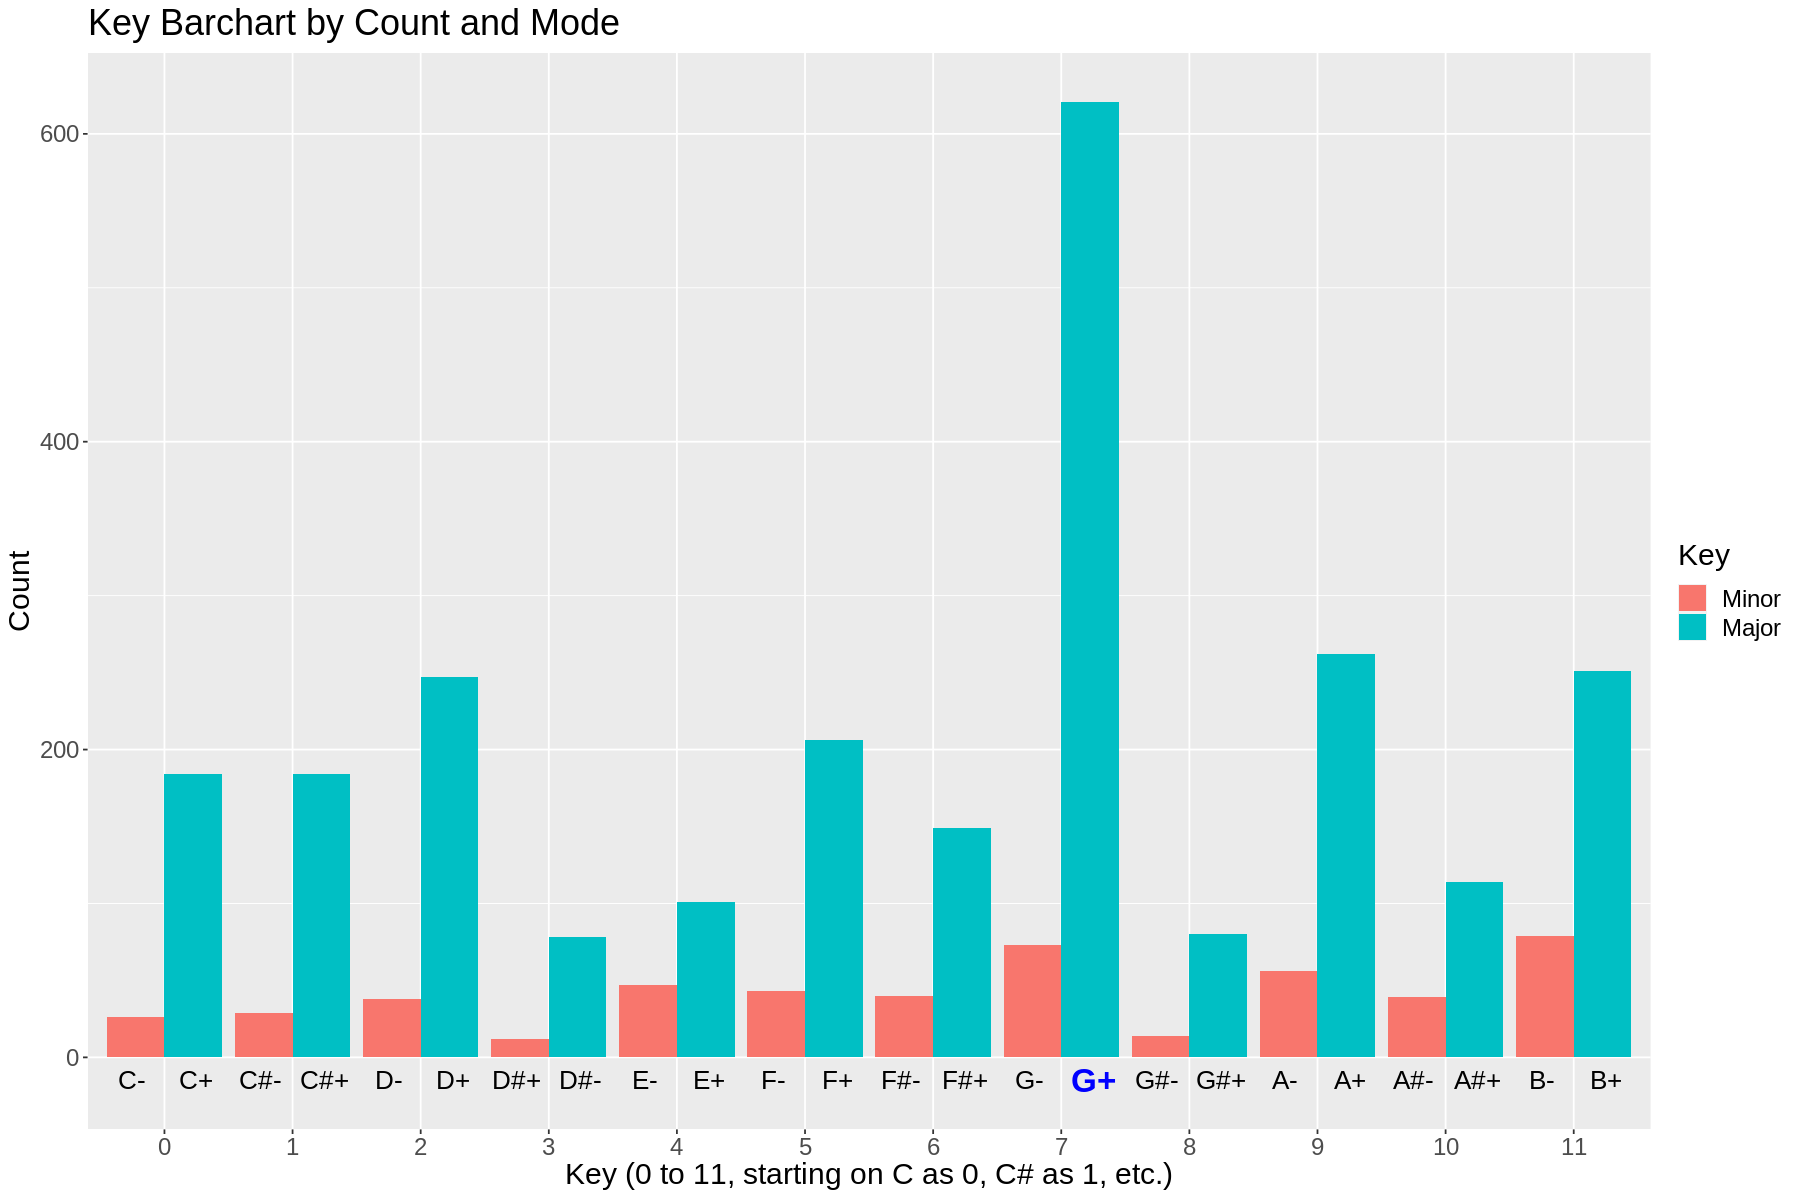

In [109]:
#Key Barchart by Count and Mode

options(repr.plot.width = 15, repr.plot.height = 10)

popularity_cat = popularity_data%>%
    select(mode,key)

key_mode_plot = ggplot(popularity_cat, aes(x=key, fill=mode))+
    geom_bar(position="dodge") + 
    labs(
        x="Key (0 to 11, starting on C as 0, C# as 1, etc.)",
        y="Count", title="Key Barchart by Count and Mode") +
    scale_fill_discrete(name = "Key", labels = c("Minor", "Major")) +
    annotate("text", x=0.75, y=-15, label = "C-", size=5.5) +
    annotate("text", x=1.25, y=-15, label = "C+", size=5.5) +
    annotate("text", x=1.75, y=-15, label = "C#-", size=5.5) +
    annotate("text", x=2.25, y=-15, label = "C#+", size=5.5) +
    annotate("text", x=2.75, y=-15, label = "D-", size=5.5) +
    annotate("text", x=3.25, y=-15, label = "D+", size=5.5) +
    annotate("text", x=3.75, y=-15, label = "D#+", size=5.5) +
    annotate("text", x=4.25, y=-15, label = "D#-", size=5.5) +
    annotate("text", x=4.75, y=-15, label = "E-", size=5.5) +
    annotate("text", x=5.25, y=-15, label = "E+", size=5.5) +
    annotate("text", x=5.75, y=-15, label = "F-", size=5.5) +
    annotate("text", x=6.25, y=-15, label = "F+", size=5.5) +
    annotate("text", x=6.75, y=-15, label = "F#-", size=5.5) +
    annotate("text", x=7.25, y=-15, label = "F#+", size=5.5) +
    annotate("text", x=7.75, y=-15, label = "G-", size=5.5) +
    annotate("text", x=8.25, y=-15, label = 'bold("G+")', size=7, colour = "blue", parse = TRUE) +
    annotate("text", x=8.75, y=-15, label = "G#-", size=5.5) +
    annotate("text", x=9.25, y=-15, label = "G#+", size=5.5) +
    annotate("text", x=9.75, y=-15, label = "A-", size=5.5) +
    annotate("text", x=10.25, y=-15, label = "A+", size=5.5) +
    annotate("text", x=10.75, y=-15, label = "A#-", size=5.5) +
    annotate("text", x=11.25, y=-15, label = "A#+", size=5.5) +
    annotate("text", x=11.75, y=-15, label = "B-", size=5.5) +
    annotate("text", x=12.25, y=-15, label = "B+", size=5.5) +

    theme(text = element_text(size = 18))


key_mode_plot

#### 2.5.2 Quantitative Variables vs. Popularity Scatterplots

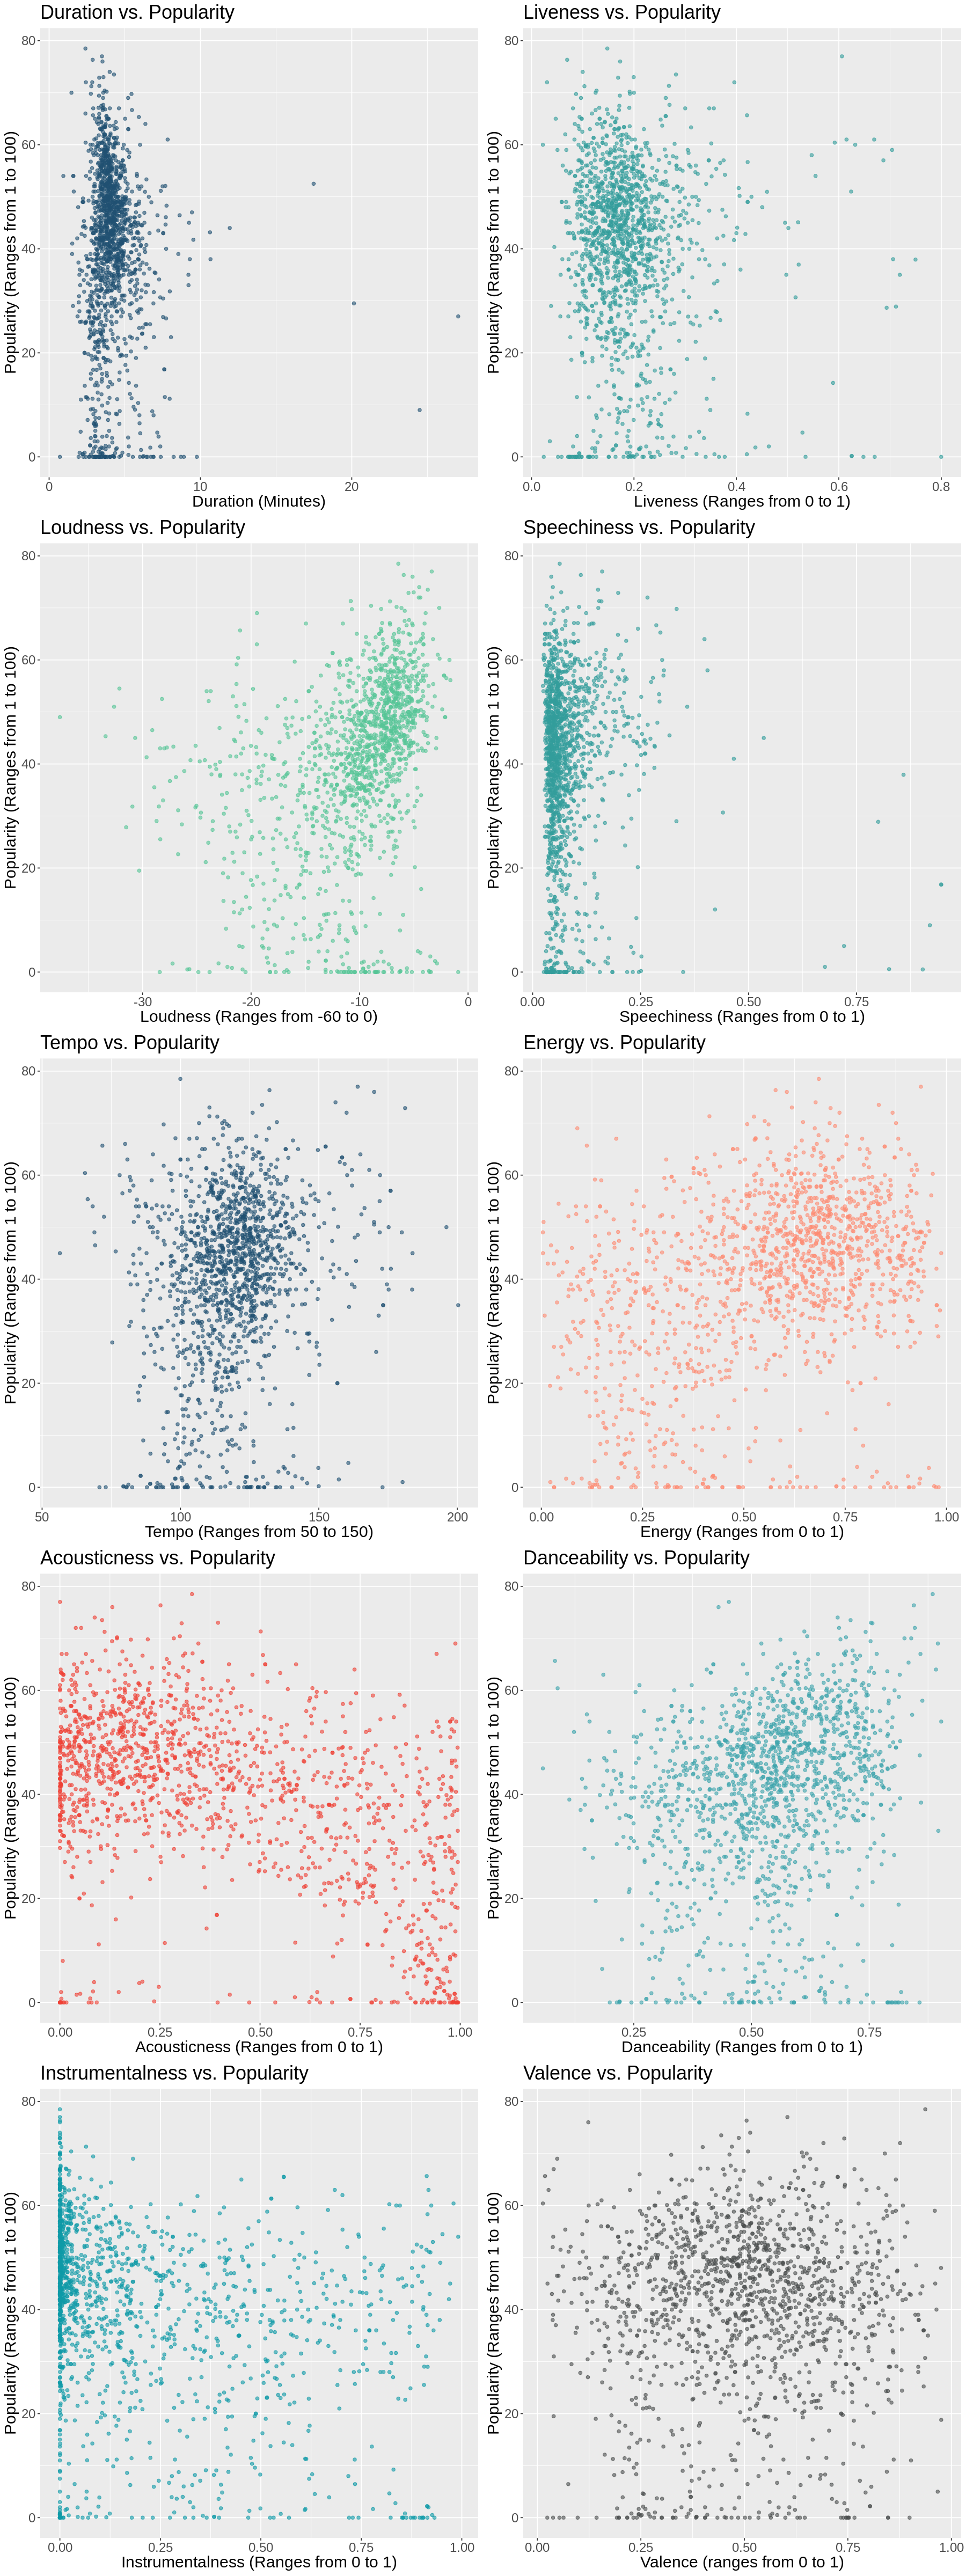

In [7]:
#Visualizations Relevant to Research

options(repr.plot.width=10, repr.plot.height=8)

duration_plot = ggplot(popularity_num2, aes(x = duration_min, y = popularity)) +
    geom_point(alpha=0.6, colour="#205072") +
    labs(
        x="Duration (Minutes)",
        y= "Popularity (Ranges from 1 to 100)",
        title= "Duration vs. Popularity"
        ) + theme(text = element_text(size = 18))

liveness_plot = ggplot(popularity_num2, aes(x = liveness, y = popularity)) +
    geom_point(alpha=0.6, colour="#329D9C") +
    labs(
        x="Liveness (Ranges from 0 to 1)",
        y= "Popularity (Ranges from 1 to 100)",
        title= "Liveness vs. Popularity"
        ) + theme(text = element_text(size = 18))

loudness_plot = ggplot(popularity_num2, aes(x = loudness, y = popularity)) +
    geom_point(alpha=0.6, colour="#56C596") +
    labs(
        x="Loudness (Ranges from -60 to 0)",
        y= "Popularity (Ranges from 1 to 100)",
        title= "Loudness vs. Popularity"
        ) + theme(text = element_text(size = 18))

speechiness_plot = ggplot(popularity_num2, aes(x = speechiness, y = popularity)) +
    geom_point(alpha=0.6, colour="#329D9C") +
    labs(
        x="Speechiness (Ranges from 0 to 1)",
        y= "Popularity (Ranges from 1 to 100)",
        title= "Speechiness vs. Popularity"
        ) + theme(text = element_text(size = 18))

tempo_plot = ggplot(popularity_num2, aes(x = tempo, y = popularity)) +
    geom_point(alpha=0.6, colour="#205072") +
    labs(
        x="Tempo (Ranges from 50 to 150)",
        y= "Popularity (Ranges from 1 to 100)",
        title= "Tempo vs. Popularity"
        ) + theme(text = element_text(size = 18))

energy_plot = ggplot(popularity_num2, aes(x = energy, y = popularity)) +
    geom_point(alpha=0.6, colour="#fe8a71") +
    labs(
        x="Energy (Ranges from 0 to 1)",
        y= "Popularity (Ranges from 1 to 100)",
        title= "Energy vs. Popularity"
        ) + theme(text = element_text(size = 18))

acousticness_plot = ggplot(popularity_num2, aes(x = acousticness, y = popularity)) +
    geom_point(alpha=0.6, colour="#ee4035") +
    labs(
        x="Acousticness (Ranges from 0 to 1)",
        y= "Popularity (Ranges from 1 to 100)",
        title= "Acousticness vs. Popularity"
        ) + theme(text = element_text(size = 18))

danceability_plot = ggplot(popularity_num2, aes(x = danceability, y = popularity)) +
    geom_point(alpha=0.6, colour="#3da4ab") +
    labs(
        x="Danceability (Ranges from 0 to 1)",
        y= "Popularity (Ranges from 1 to 100)",
        title= "Danceability vs. Popularity"
        ) + theme(text = element_text(size = 18))

instrumentalness_plot = ggplot(popularity_num2, aes(x = instrumentalness, y = popularity)) +
    geom_point(alpha=0.6, colour="#0e9aa7") +
    labs(
        x="Instrumentalness (Ranges from 0 to 1)",
        y= "Popularity (Ranges from 1 to 100)",
        title= "Instrumentalness vs. Popularity"
        ) + theme(text = element_text(size = 18))

valence_plot = ggplot(popularity_num2, aes(x = valence, y = popularity)) +
    geom_point(alpha=0.6, colour="#4a4e4d") +
    labs(
        x="Valence (ranges from 0 to 1)",
        y= "Popularity (Ranges from 1 to 100)",
        title= "Valence vs. Popularity"
        ) + theme(text = element_text(size = 18))

options(repr.plot.width = 15, repr.plot.height = 40)
plot_grid(duration_plot, liveness_plot, loudness_plot, speechiness_plot, tempo_plot, energy_plot,
          acousticness_plot, danceability_plot, instrumentalness_plot, valence_plot, ncol = 2)

#### 2.5.3 Ggpairs Multivariate Analysis

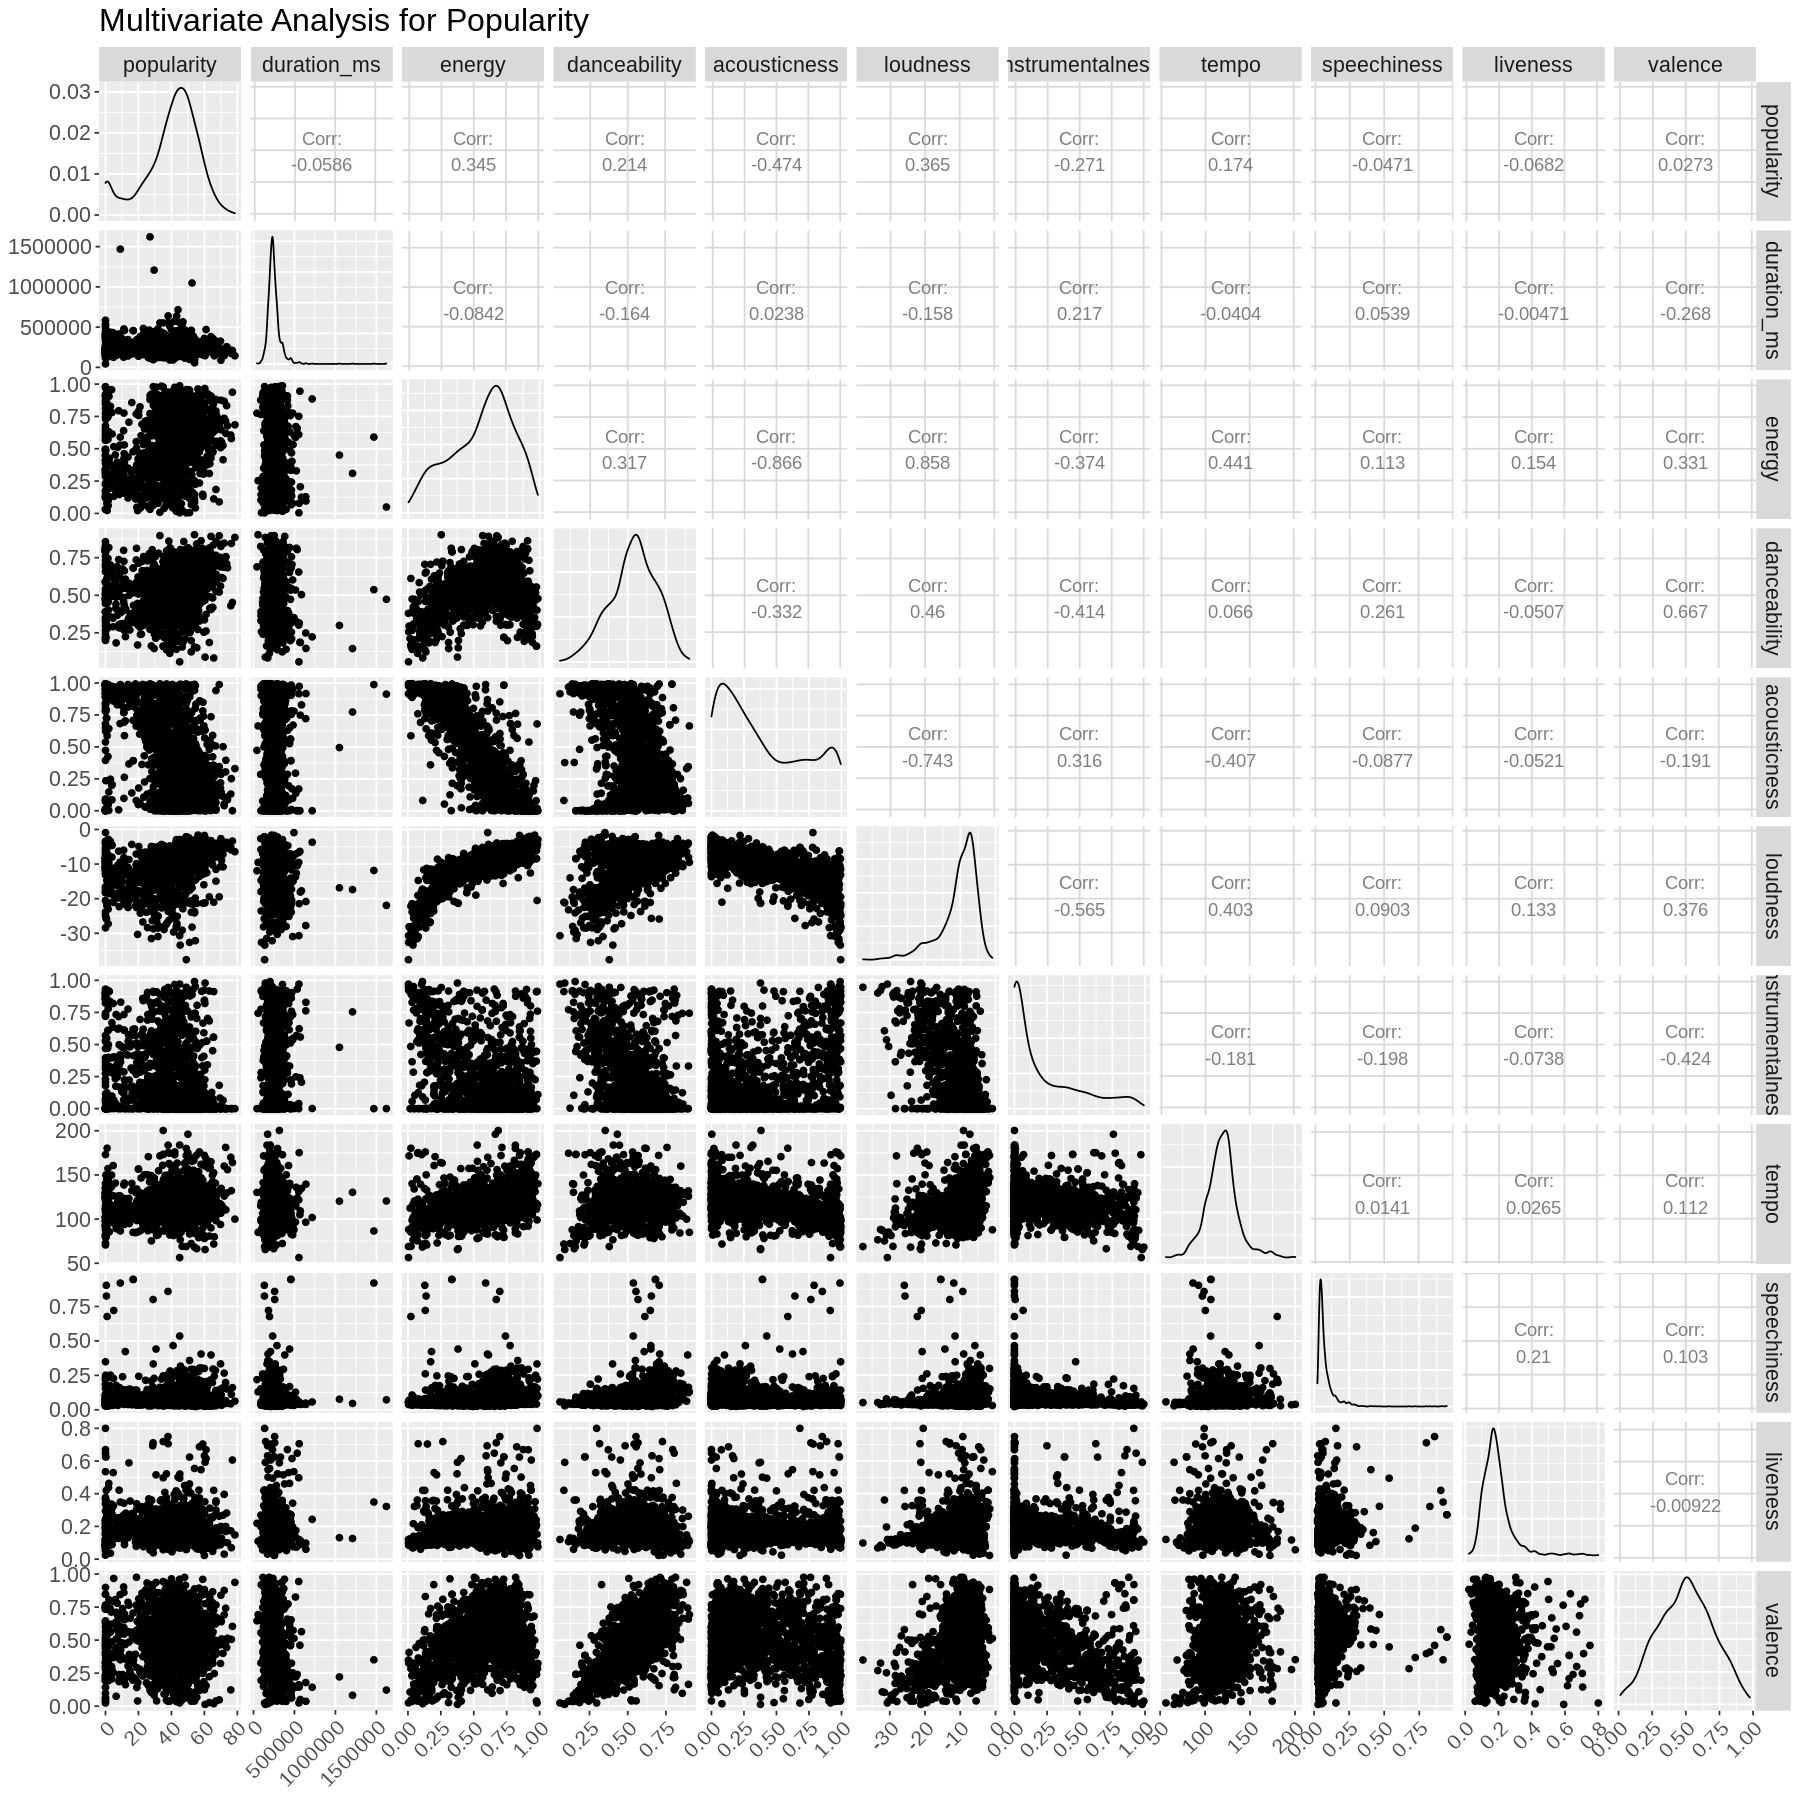

In [8]:
options(repr.plot.width = 15, repr.plot.height = 15)

#GGpairs Plot
pair_plot = popularity_training %>%
    select(popularity, duration_ms, energy, danceability, acousticness, loudness, instrumentalness, tempo, speechiness,liveness, valence) %>%
    ggpairs() + 
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
    theme(text = element_text(size = 16)) + 
    ggtitle("Multivariate Analysis for Popularity")

pair_plot

In [9]:
set.seed(4002)

popularity_recipe = recipe(popularity ~ energy + acousticness + loudness, data = popularity_training)

pop_spec = nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("regression")

pop_vfold = vfold_cv(popularity_training, v = 5, strata = popularity)

pop_wkflw = workflow() %>%
    add_recipe(popularity_recipe) %>%
    add_model(pop_spec)

pop_wkflw

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [10]:
set.seed(4002)
gridvals = tibble(neighbors = seq(1,40))

pop_results = pop_wkflw %>%
    tune_grid(resamples = pop_vfold, grid = gridvals) %>%
    collect_metrics()%>%
    filter(.metric=="rmse")

head(pop_results)
tail(pop_results)

neighbors .metric .estimator mean     n std_err   .config
1 1         rmse    standard   16.62441 5 0.2569124 Model01
2 2         rmse    standard   14.65455 5 0.1609636 Model02
3 3         rmse    standard   13.92290 5 0.2436815 Model03
4 4         rmse    standard   13.70328 5 0.2298886 Model04
5 5         rmse    standard   13.50132 5 0.1611255 Model05
6 6         rmse    standard   13.34686 5 0.1433867 Model06

neighbors .metric .estimator mean     n std_err   .config
1 35        rmse    standard   12.92044 5 0.1810616 Model35
2 36        rmse    standard   12.92874 5 0.1800058 Model36
3 37        rmse    standard   12.92903 5 0.1898501 Model37
4 38        rmse    standard   12.93510 5 0.1892644 Model38
5 39        rmse    standard   12.92784 5 0.1840546 Model39
6 40        rmse    standard   12.93577 5 0.1813346 Model40

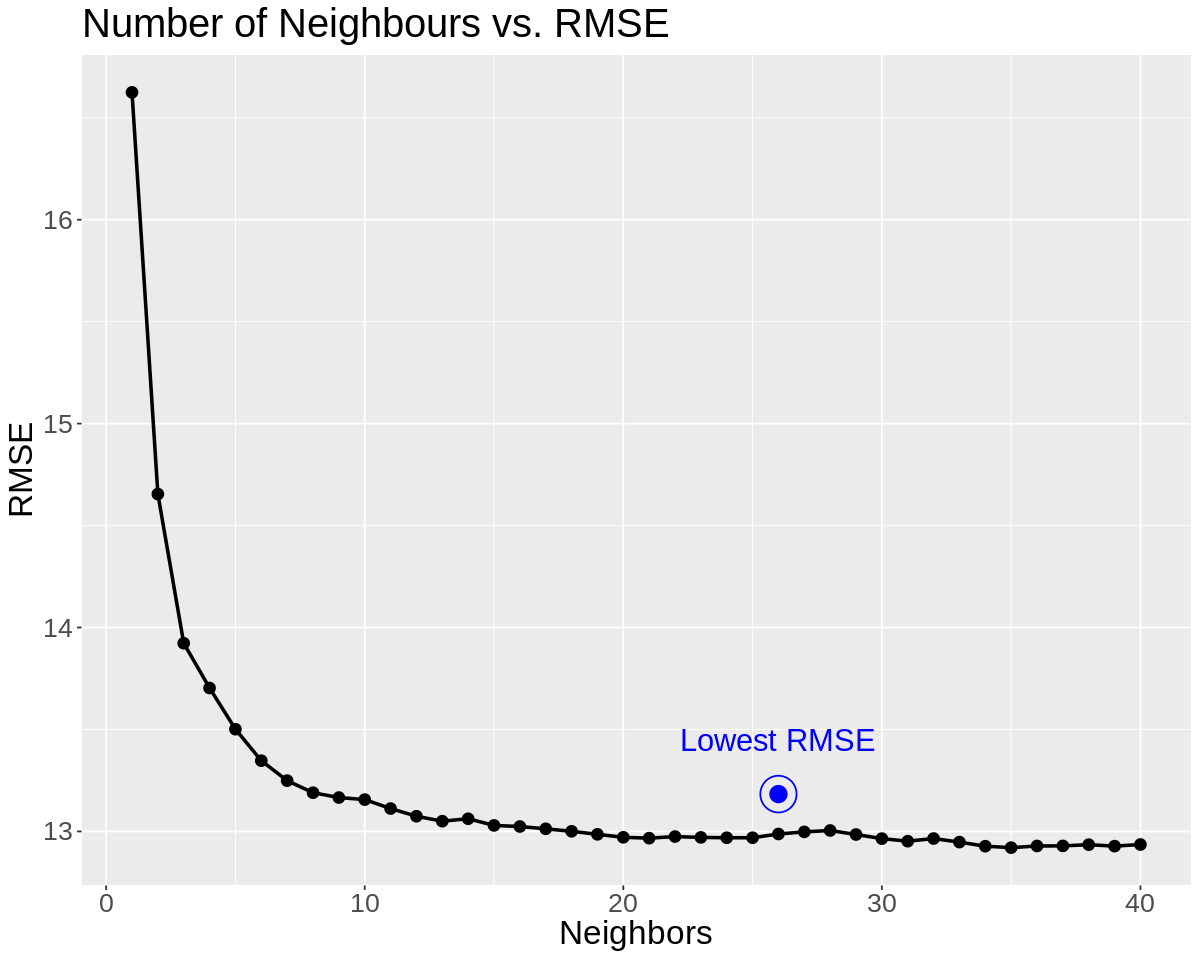

In [11]:
options(repr.plot.width = 10, repr.plot.height = 8)
bestk_graph = ggplot(pop_results, aes(x=neighbors, y=mean)) +
    geom_point(size=2.9)+
    geom_line(size=1)+
    labs(x= "Neighbors", y= "RMSE") +
    ggtitle("Number of Neighbours vs. RMSE") +
    theme(text = element_text(size = 20))+
    annotate("point",x=26, y=13.18306, colour="blue", size=4.5)+
    annotate("text", x=26, y=13.45, label = "Lowest RMSE", size=6.5, colour="blue")+
    annotate("path", 
                 x=26 + 0.7*cos(seq(0,2*pi,length.out=100)),
                 y=13.18306 + 0.09*sin(seq(0,2*pi,length.out=100)), colour="blue")

bestk_graph

In [12]:
pop_min = pop_results %>% 
    arrange(mean) %>%
    slice(1)
pop_min

neighbors .metric .estimator mean     n std_err   .config
1 35        rmse    standard   12.92044 5 0.1810616 Model35

In [13]:
set.seed(4002)
kmin = pop_min %>%
    pull(neighbors)

pop_spec = nearest_neighbor(weight_func = "rectangular", neighbors = kmin) %>%
    set_engine("kknn") %>%
    set_mode("regression")

pop_fit = workflow() %>%
    add_recipe(popularity_recipe) %>%
    add_model(pop_spec) %>%
    fit(data = popularity_training)

pop_summary = pop_fit %>%
    predict(popularity_testing) %>%
    bind_cols(popularity_testing) %>%
    metrics(truth = popularity, estimate = .pred)

pop_summary

.metric .estimator .estimate 
1 rmse    standard   13.6993560
2 rsq     standard    0.3608862
3 mae     standard    9.8205007

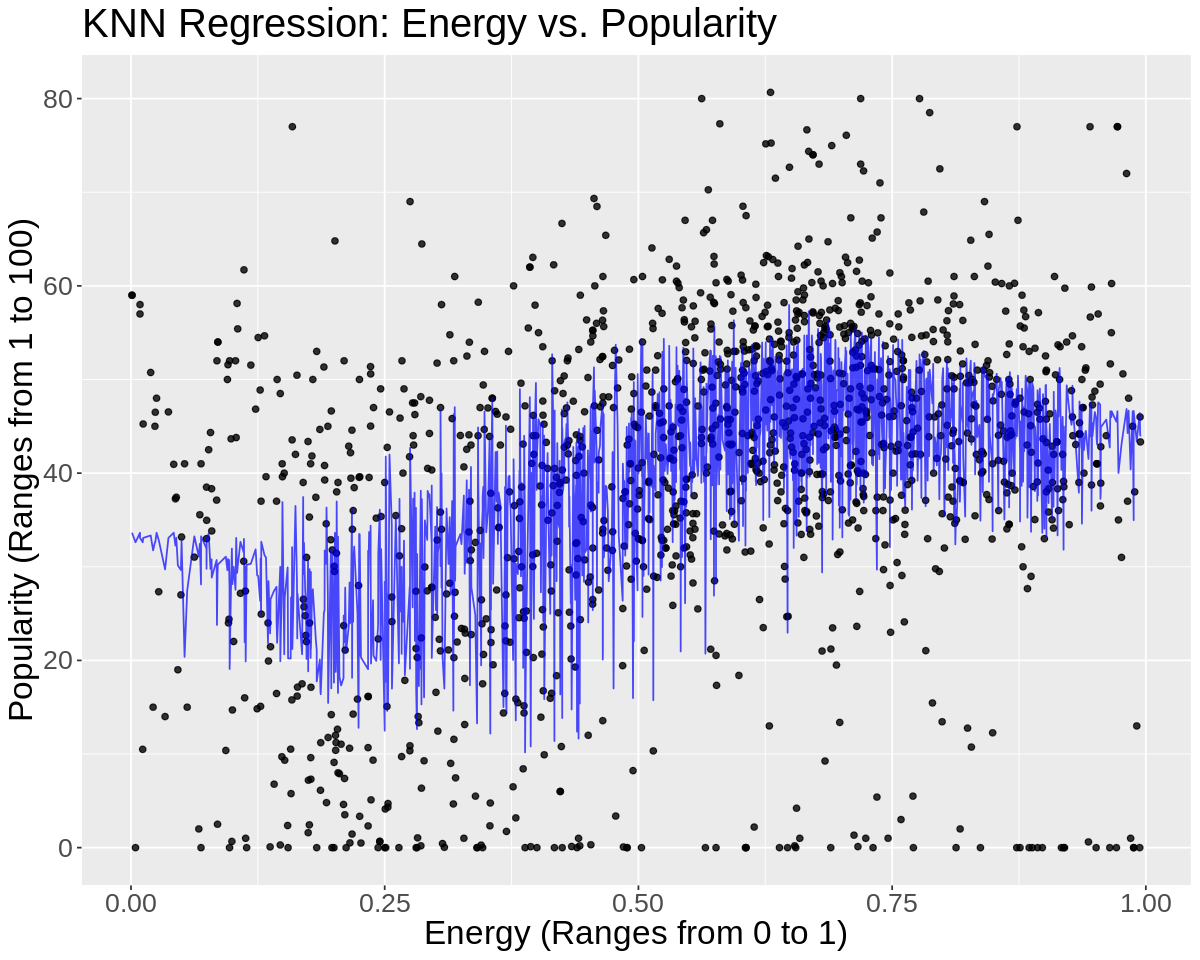

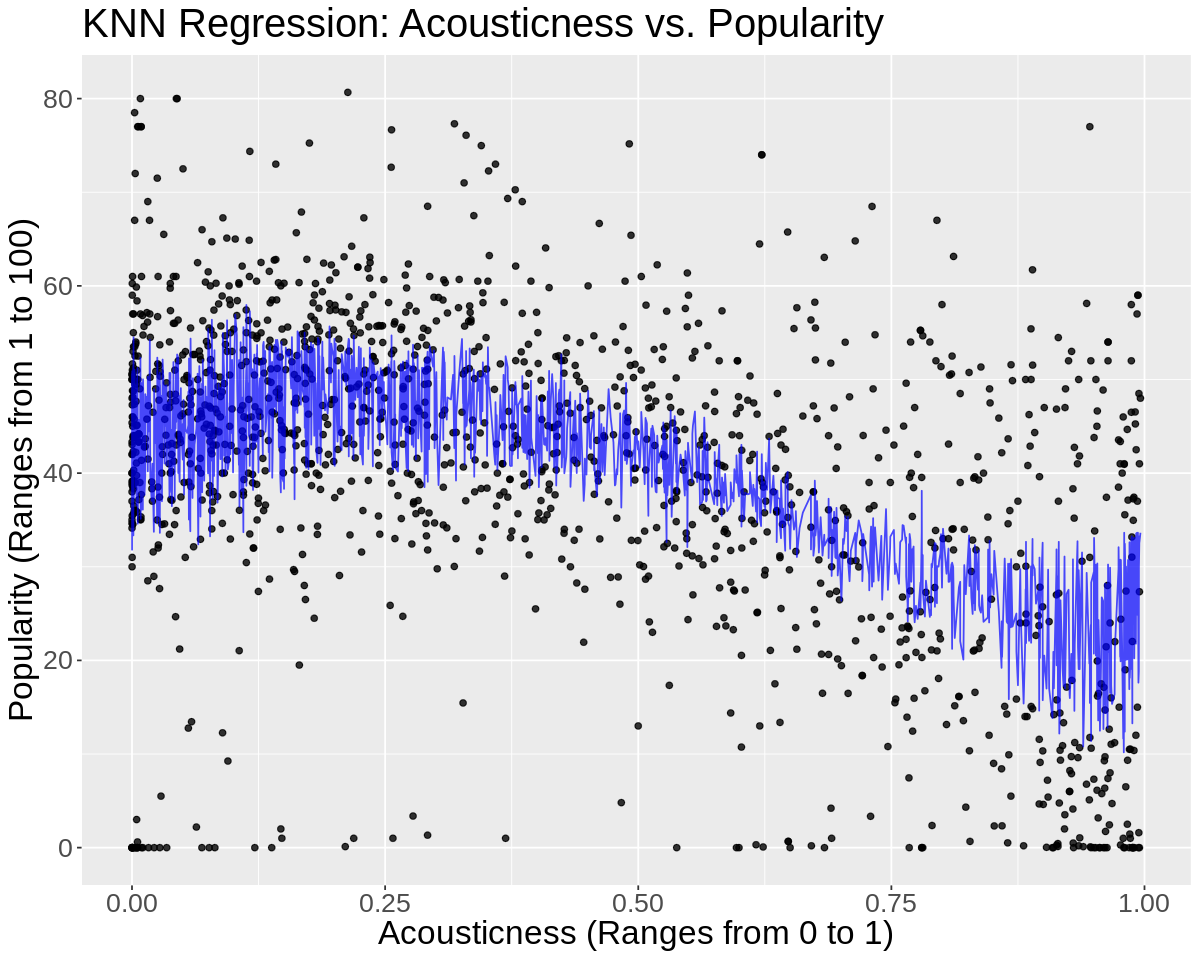

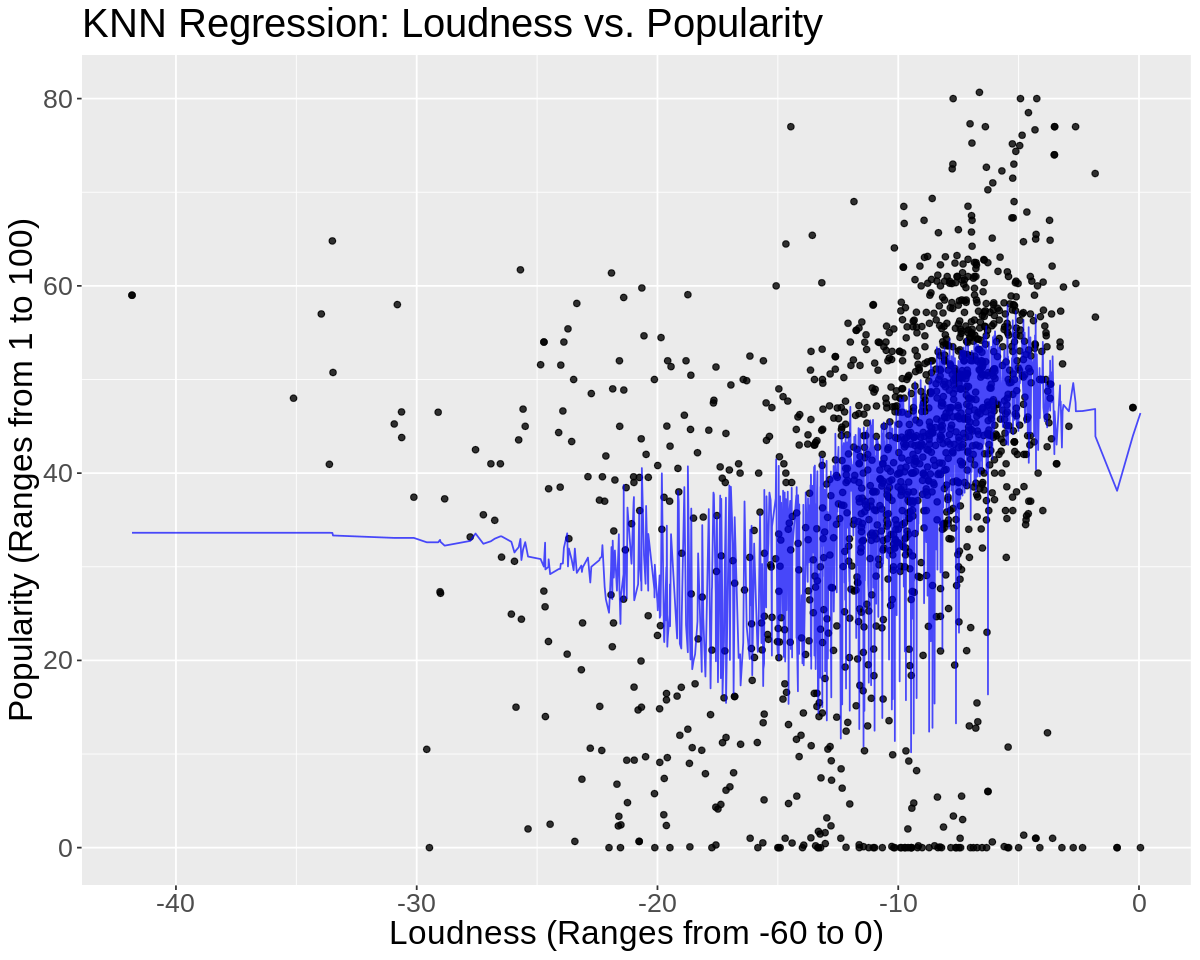

In [14]:
#Knn Regression Visualization
options(repr.plot.width = 10, repr.plot.height = 8)
pred_table <- pop_fit %>%
    predict(popularity_testing) %>%
    bind_cols(popularity_testing)

knn_energy_plot <- ggplot(pred_table, aes(x=energy, y=popularity)) +
    geom_point(alpha=0.8) +
    labs(
        x="Energy (Ranges from 0 to 1)",
        y= "Popularity (Ranges from 1 to 100)",
        title= "KNN Regression: Energy vs. Popularity"
        ) +
    theme(text = element_text(size = 20)) +
    geom_line(data = pred_table, aes(x=energy, y=.pred), color = "blue", alpha=0.7)

knn_energy_plot

knn_acousticness_plot <- ggplot(pred_table, aes(x=acousticness, y=popularity)) +
    geom_point(alpha=0.8) +
    labs(
        x="Acousticness (Ranges from 0 to 1)",
        y= "Popularity (Ranges from 1 to 100)",
        title= "KNN Regression: Acousticness vs. Popularity"
        ) + theme(text = element_text(size = 20)) +
    geom_line(data = pred_table, aes(x=acousticness, y=.pred), color = "blue", alpha=0.7)

knn_acousticness_plot

knn_loudness_plot <- ggplot(pred_table, aes(x=loudness, y=popularity)) +
    geom_point(alpha=0.8) +
   labs(
        x="Loudness (Ranges from -60 to 0)",
        y= "Popularity (Ranges from 1 to 100)",
        title= "KNN Regression: Loudness vs. Popularity"
        ) + theme(text = element_text(size = 20)) +
    geom_line(data = pred_table, aes(x=loudness, y=.pred), color = "blue", alpha=0.7)

knn_loudness_plot
options(repr.plot.width = 25, repr.plot.height = 15)

In [15]:
set.seed(4002)
#Simple Linear Regression

lm_recipe = recipe(popularity ~ energy + acousticness + loudness, data = popularity_training)

lm_spec = linear_reg() %>%
    set_engine("lm") %>%
    set_mode("regression")

lm_fit = workflow() %>%
    add_recipe(lm_recipe) %>%
    add_model(lm_spec) %>%
    fit(data=popularity_training) 

lm_fit

#find coefficients of best-fit line#

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
 (Intercept)        energy  acousticness      loudness  
     81.9640      -33.9948      -36.0104        0.8077  


$Popularity  = 74.560 -26.414*Energy  -32.394*Acousticness +0.625*Loudness$

In [16]:
#RMSE CALCULATION

lm_rmse = lm_fit %>%
    predict(popularity_training) %>%
    bind_cols(popularity_training) %>%
    metrics(truth = popularity, estimate = .pred) %>%
    filter(.metric == "rmse") %>%
    select(.estimate) %>%
    pull()

lm_rmse

#RMSPE CALCULATION

lm_rmspe = lm_fit %>%
     predict(popularity_testing) %>%
     bind_cols(popularity_testing) %>%
     metrics(truth = popularity, estimate = .pred)%>%
     filter(.metric == "rmse") %>%
     select(.estimate) %>%
     pull()

lm_rmspe

[1] 14.08639

[1] 15.16438

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



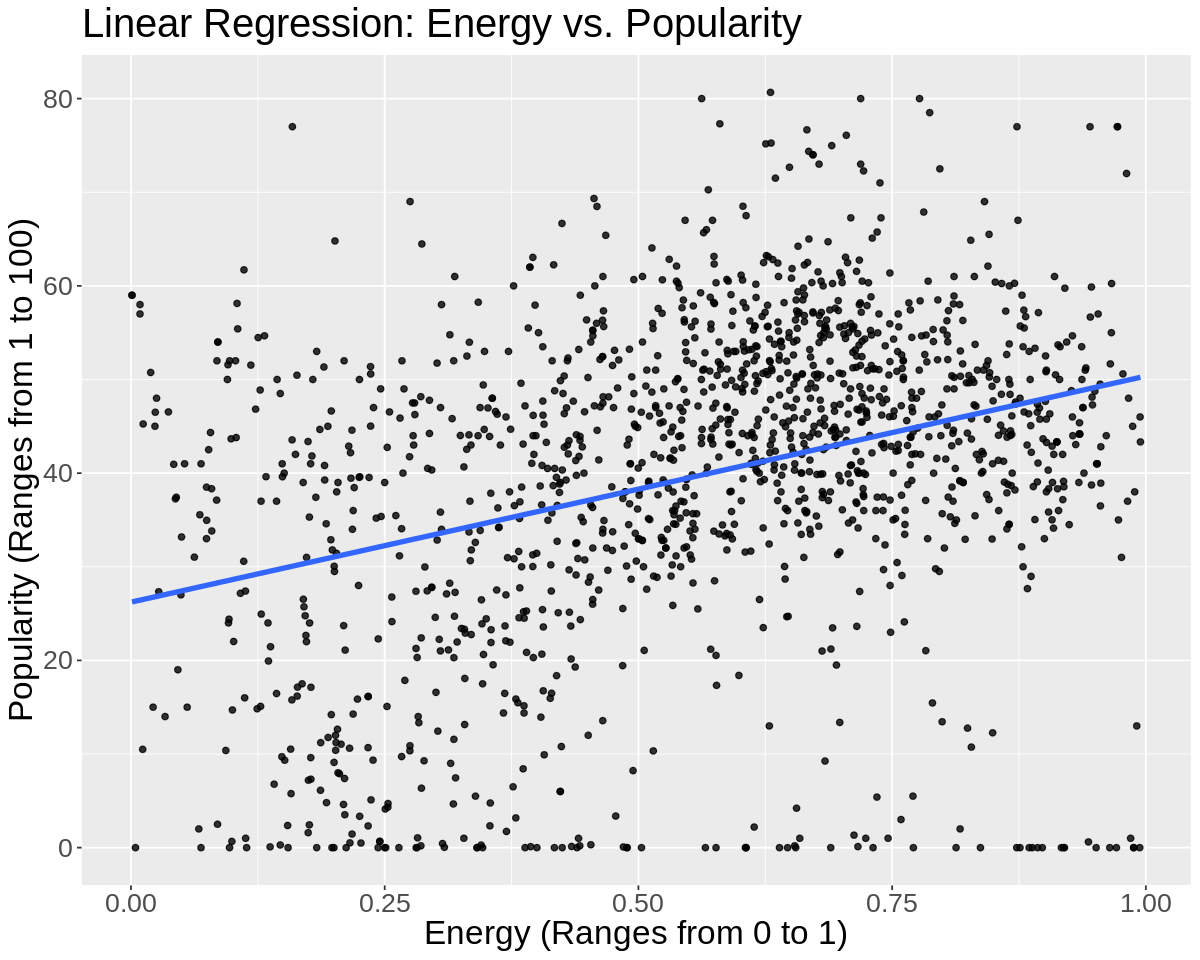

`geom_smooth()` using formula 'y ~ x'



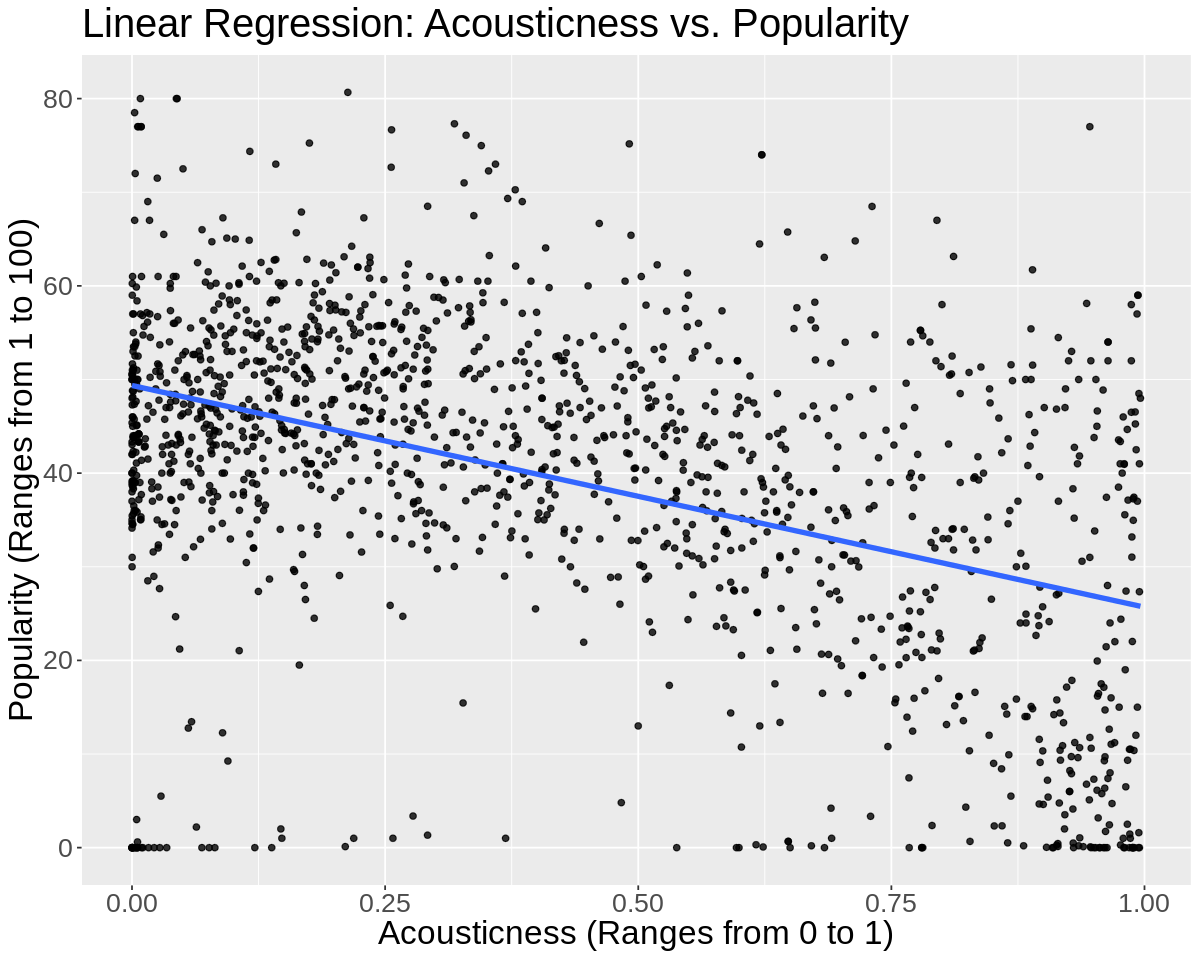

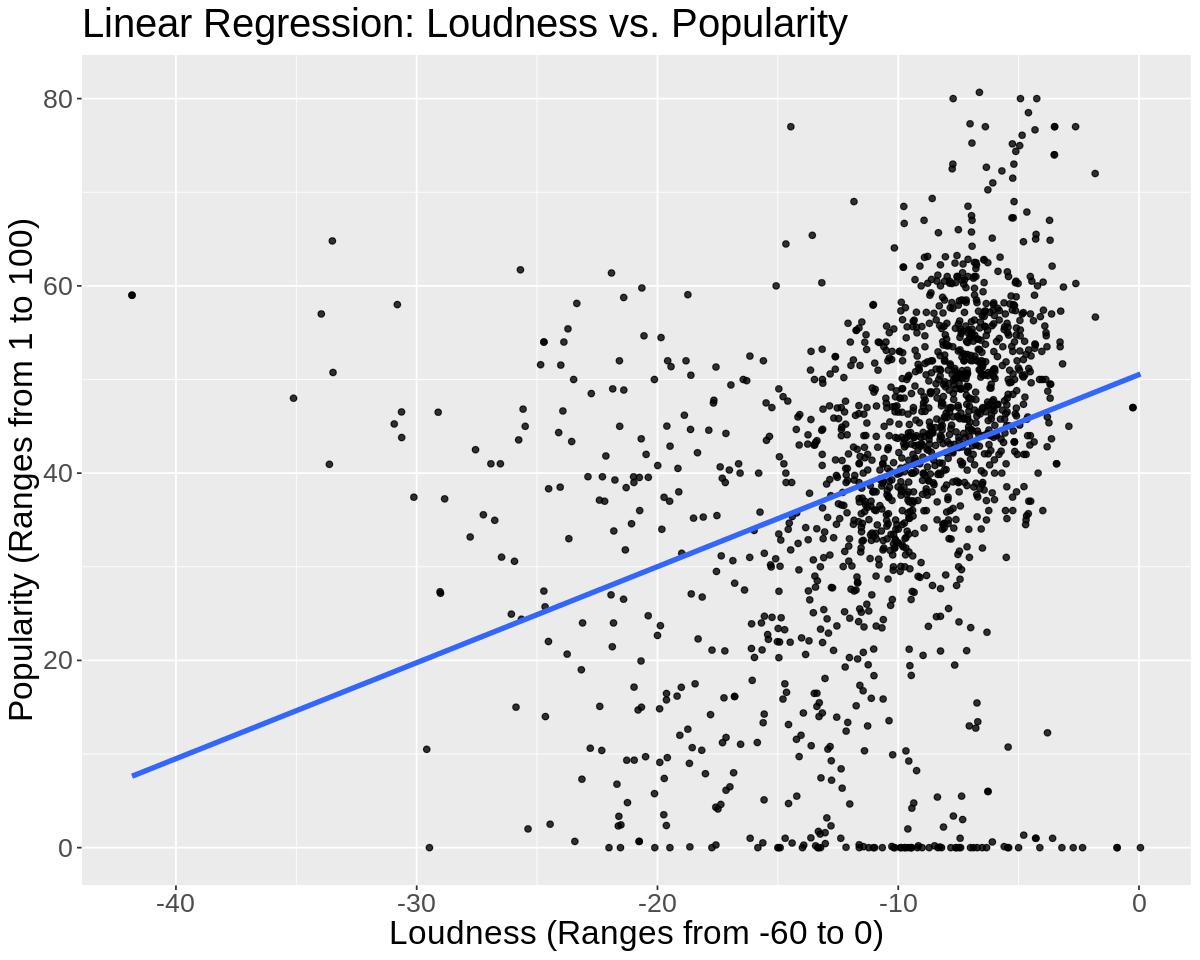

In [17]:
#Visualization for LM model
options(repr.plot.width = 10, repr.plot.height = 8)
lm_table = lm_fit%>%
    predict(popularity_testing) %>%
    bind_cols(popularity_testing)

lm_energy_plot = ggplot(lm_table, aes(x = energy, y = popularity)) +
    geom_point(alpha=0.8) +
    labs(
        x="Energy (Ranges from 0 to 1)",
        y= "Popularity (Ranges from 1 to 100)",
        title= "Linear Regression: Energy vs. Popularity "
        ) + theme(text = element_text(size = 20)) +
    geom_smooth(method = "lm", se = FALSE, size=1.5)

lm_energy_plot

lm_acousticness_plot = ggplot(lm_table, aes(x = acousticness, y = popularity)) +
    geom_point(alpha=0.8) +
    labs(
        x="Acousticness (Ranges from 0 to 1)",
        y= "Popularity (Ranges from 1 to 100)",
        title= "Linear Regression: Acousticness vs. Popularity"
        )  + theme(text = element_text(size = 20)) +
    geom_smooth(method = "lm", se = FALSE, size=1.5)

lm_acousticness_plot

lm_loudness_plot = ggplot(lm_table, aes(x = loudness, y = popularity)) +
    geom_point(alpha=0.8) +
    labs(
        x="Loudness (Ranges from -60 to 0)",
        y= "Popularity (Ranges from 1 to 100)",
        title= "Linear Regression: Loudness vs. Popularity"
        ) + theme(text = element_text(size = 20)) +
    geom_smooth(method = "lm", se = FALSE, size=1.5)

lm_loudness_plot

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



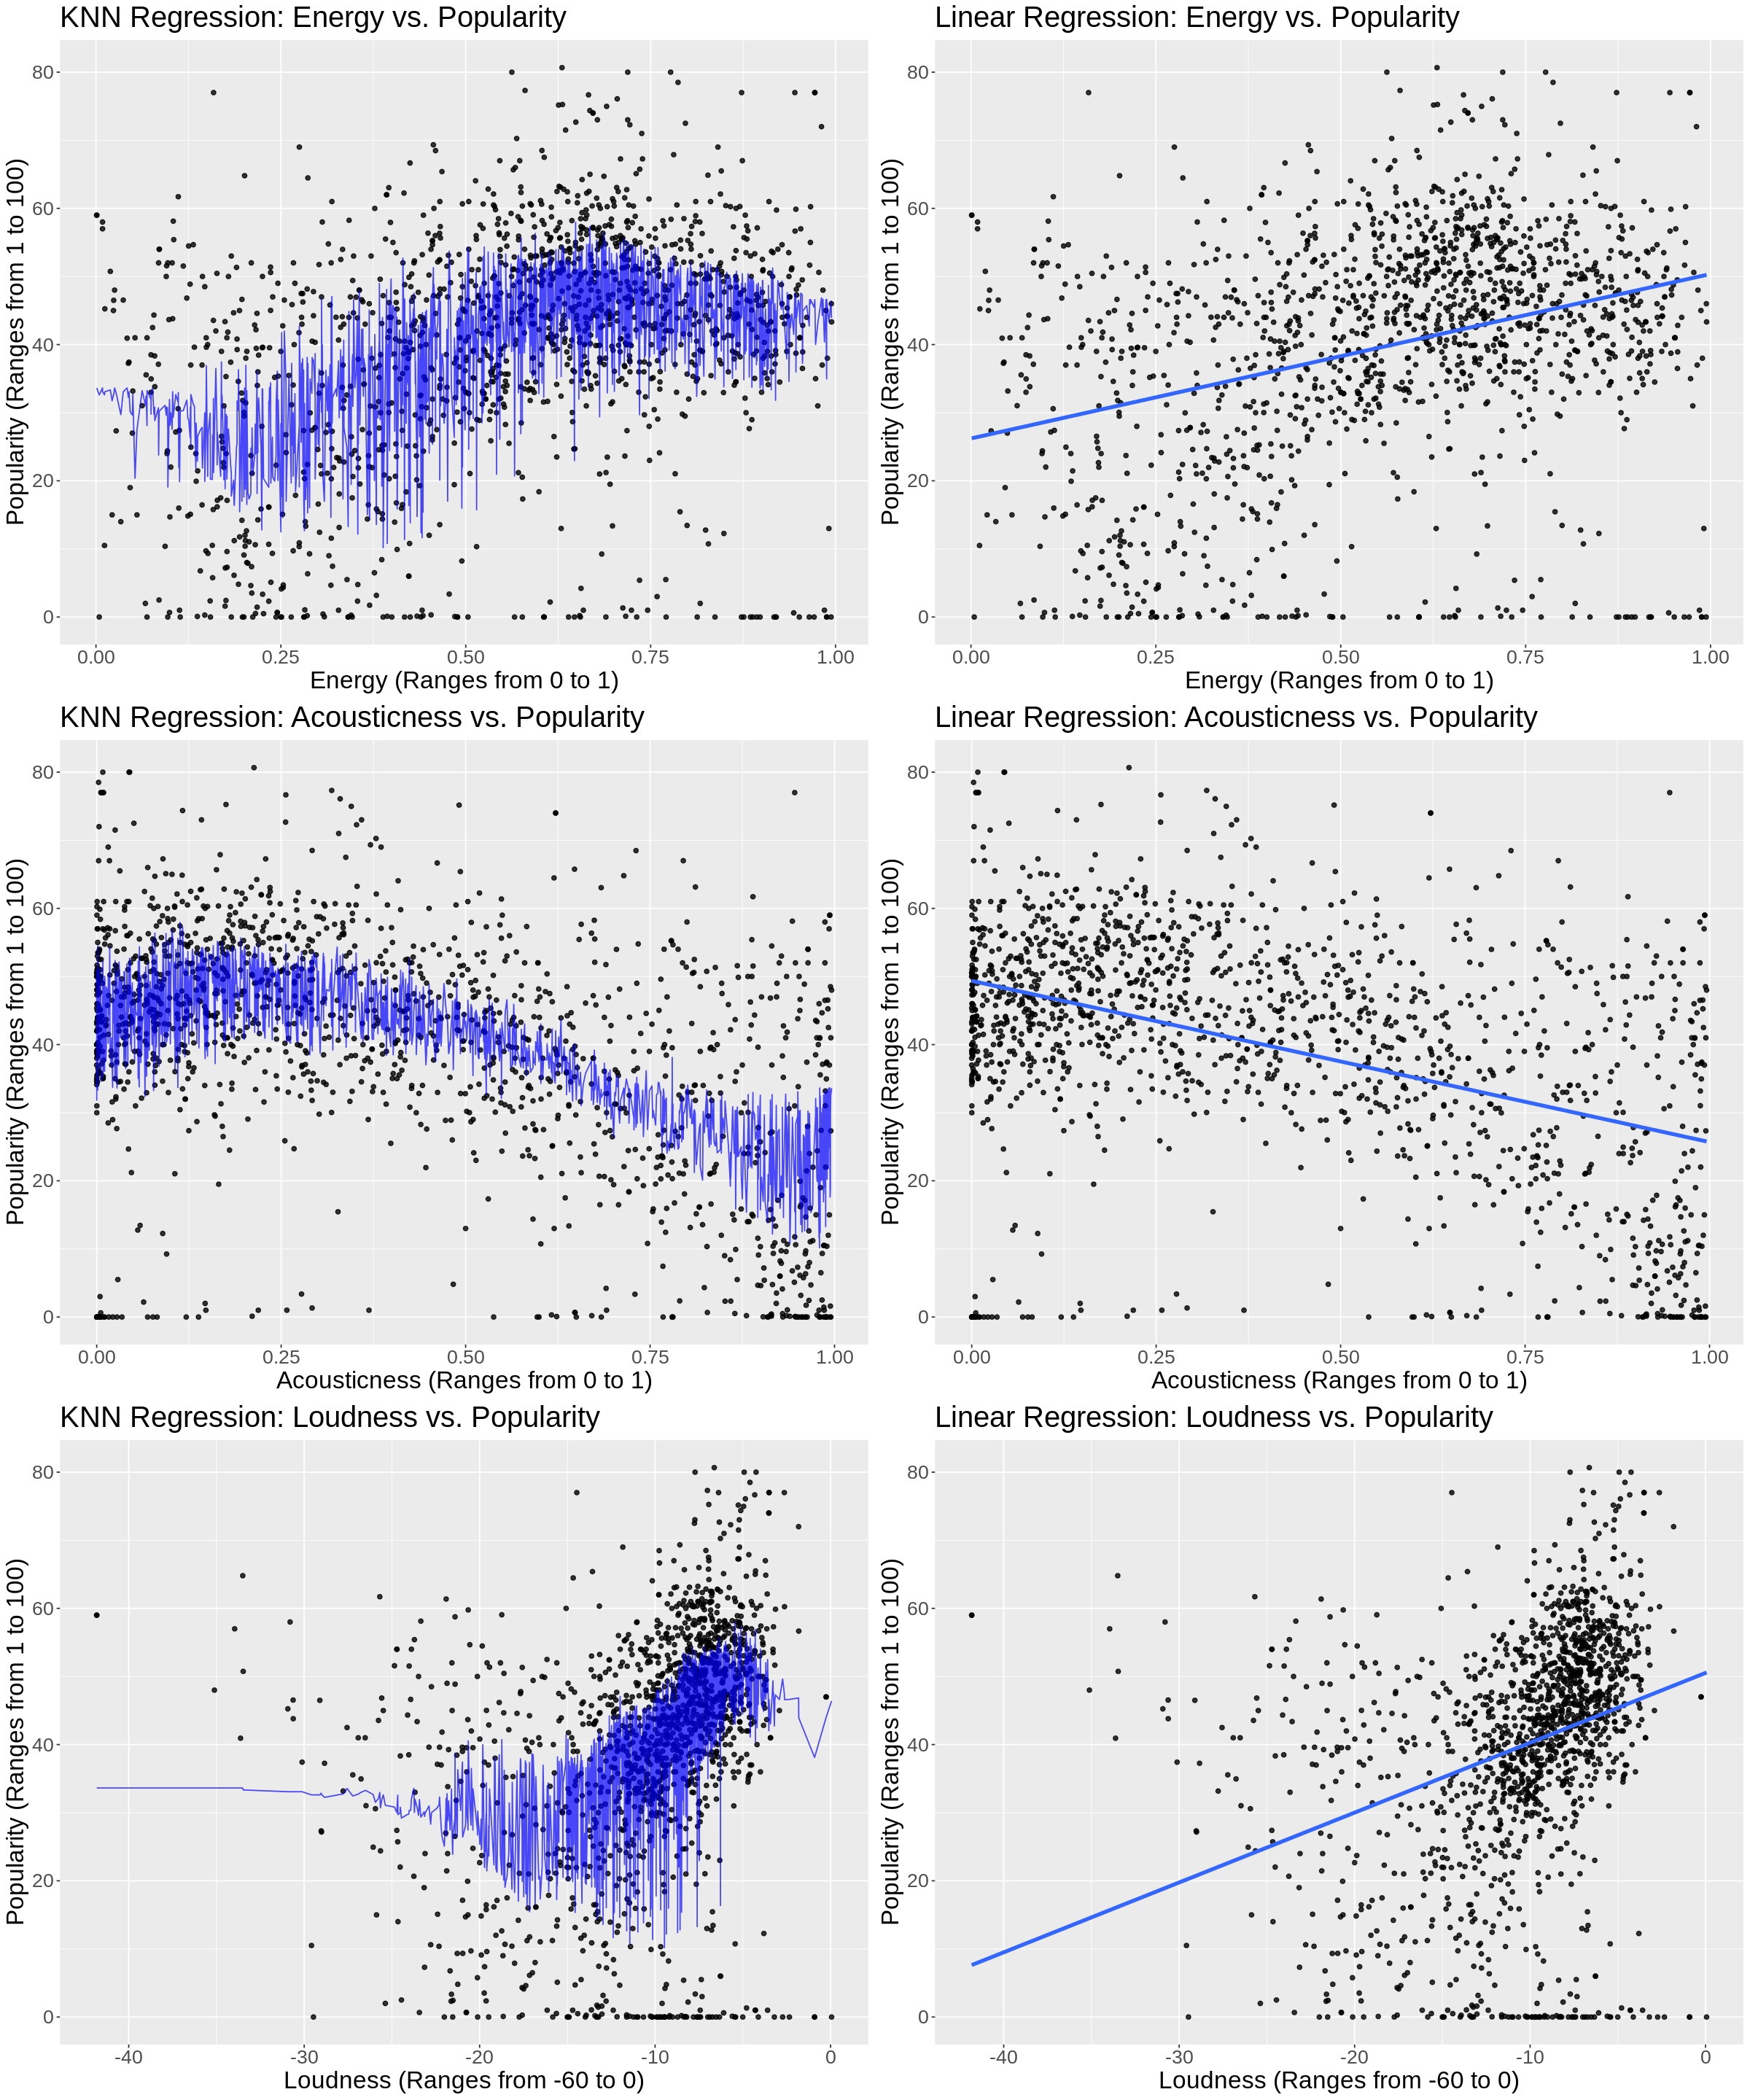

In [18]:
#KNN vs. Simple Linear Side-by-side
options(repr.plot.width = 20, repr.plot.height = 24)

plot_grid(knn_energy_plot, lm_energy_plot, knn_acousticness_plot, lm_acousticness_plot, knn_loudness_plot, lm_loudness_plot, ncol=2)

## 3 Methods
### 3.1 Data Wrangling

Wrangling and tidying is a necessary first step to all data analysis procedures. From the raw dataset imported, we manually sorted through them to find 3 categorical and 11 quantitative variables (See 2.2 for details). Although k-nearest neighbors classification and regression only predicts quantitative inputs, we believe it is still worthwhile to explore the categorical variables within the preliminary analysis to discover potential trends relevant to the final discussion (See 2.5.1 for an example). 

### 3.2 Variable selection and Analysis

Regarding the selection of the quantitative variables, the objective of a regression model is not to perfectly replicate real life with an unbounded set of variables, but to predict outcomes using carefully-selected, *impactful variables*.

*“Everything should be made as simple as possible, but not simpler”*
-Albert Einstein

To screen for key variables, each quantitative variable is passed through a multivariate analysis plot from ggpairs() against popularity (See 2.5.4 for details). This method allows us to compare the correlation coefficients -- determining the relevance of each variable. From the current analysis in section 2.5.4, Energy, acousticness, and loudness have the highest correlation to popularity. Furthermore, we plan to implement multiple trials of 5-fold cross validation while tuning the neighbors in the final analysis to assess other variables' potential impact on a song’s popularity.

Finally, because the dataset has 2,973 observations, we confidently chose a 50/50 split  because a reasonably large dataset allows for more observations to be dedicated to testing without compromising accuracy from the training side.


### 3.3 Visualization of Results 

The regression analysis described previously can have two potential visualizations. Of these two, the standard is an underfitting vs overfitting plot to show the optimal K selection. For the complex visualization, we plan to plot our KNN regression line for each variable individually against popularity to compare the accuracy of each variable, since no methods exist that allow us to plot on 2+ dimensions.

## 4 Conclusion

By following the methods outlined above, we intend to create a model that is capable of determining a song's expected popularity before its release, which could have real-world applications in the music industry. Building upon this analysis, we can also investigate how song features change based on demographics and how popularity relates to non-musical factors such as investment and marketing. 